In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from importlib import reload
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens
from src.scoring_functions import cosine_sim, entropy
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

## Creating RecommenderSystem on MovieLens 

In [3]:
n_attrs=500
max_iter=1000
n_clusters=20

In [4]:
binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')

In [5]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.


In [6]:
# Define topic clusters using NMF
item_topics = get_topic_clusters(binary_ratings_matrix, n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Loaded clusters.


In [104]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_user_rep = scaler.fit_transform(user_representation)

kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=10, max_iter=300, random_state=42)
user_clusters = kmeans.fit_predict(scaled_user_rep)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_user_rep)
pcadf = pd.DataFrame(data = principalComponents, columns = ['component_1', 'component_2'])
pcadf['predicted_cluster'] = user_clusters
print(pca.explained_variance_ratio_)

[0.02569702 0.02039239]


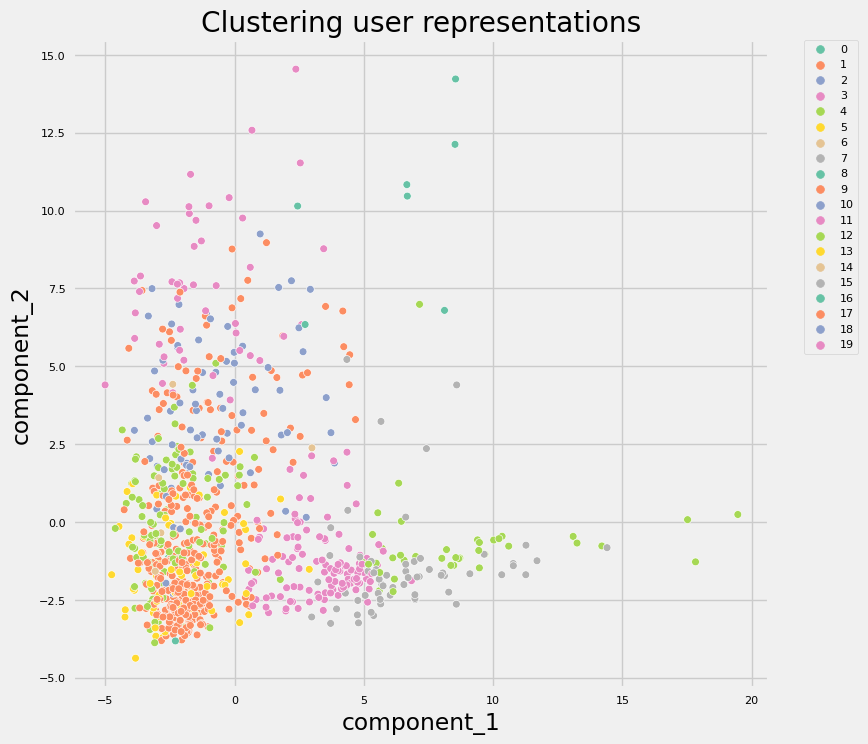

In [103]:
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    x="component_1",
    y="component_2",
    data=pcadf,
    hue="predicted_cluster",
    palette="Set2",
)

scat.set_title("Clustering user representations")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [7]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns

# Using user representation and clusters from NMF to visualize user separation
# x = user_representation
# y = user_representation.argmax(axis=1)

# tsne = TSNE(n_components=2, verbose=1, random_state=42)
# z = tsne.fit_transform(x)
# df = pd.DataFrame()
# df["y"] = y
# df["comp-1"] = z[:,0]
# df["comp-2"] = z[:,1]

# print(f"Number of clusters using NMF: {n_attrs}.")
# sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                 palette=sns.color_palette("hls", n_attrs),
#                 data=df).set(title="")

In [68]:
views_per_cluster = pd.DataFrame(binary_ratings_matrix).copy().T
views_per_cluster['cluster'] = item_topics
views_per_cluster = views_per_cluster.groupby('cluster').sum()
views_per_cluster = views_per_cluster.T
views_per_cluster.idxmax(axis=1)

0      4
1      2
2      0
3      2
4      6
      ..
938    2
939    3
940    2
941    0
942    6
Length: 943, dtype: int64

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.111742
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.246788
[t-SNE] KL divergence after 4450 iterations: 0.848001


[Text(0.5, 1.0, '')]

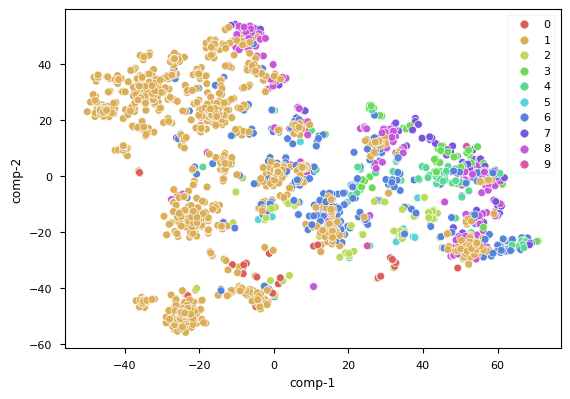

In [69]:
# Using item_representation and KNN on co-occurence matrix to visualize item cluster
x = item_representation.T
y = item_topics

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=5000, random_state=42)
z = tsne.fit_transform(x)
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", n_clusters),
                data=df).set(title="")

In [17]:
#TODO: Histogram of users per cluster

# Simulation

### Plotting Functions

In [160]:
def plot_histograms(model, measurements_df):
    # for every 10 timesteps plot line in different color
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))

    for i in range(10, timesteps+10, 10):
        ax[0].plot(np.arange(model.num_items), sorted(measurements_df['interaction_histogram'][i]), label=f't={i}')
        ax[1].plot(np.arange(model.num_items), sorted(measurements_df['topic_interaction_histogram'][i]), label=f't={i}')

    ax[0].set_title('Interaction Histogram')
    ax[0].set_xlabel('Items')
    ax[0].set_ylabel('# Interactions')
    ax[0].legend()
    # ax[1].set_title('Topic Interaction Similarity')
    # ax[1].set_xlabel('Topics')
    # ax[1].set_ylabel('# Interactions')
    # ax[1].legend()

In [24]:
def plot_measurements(dfs, parameters_df):

    fig, ax = plt.subplots(2, 3, figsize=(15, 15))
    fig.tight_layout(pad=5.0)

    # plot rec_similarity with timesteps on x axis
    legend_lines, legend_names = [], []
    for i, df in enumerate(dfs):
        ts = df['timesteps']
        name = parameters_df.loc[i, 'model_name']
        if not np.isnan(parameters_df.loc[i, 'Lambda']):
             name += f" (Lambda: {parameters_df.loc[i, 'Lambda']})" 
        legend_names.append(name)
        ax[0,0].plot(ts, df['mse'], label=name)
        ax[0,1].plot(ts, df['rec_similarity'], label=name)
        ax[0,2].plot(ts, df['interaction_similarity'], label=name)
        ax[1,0].plot(ts, df['serendipity_metric'], label=name)
        ax[1,1].plot(ts, df['novelty_metric'], label=name)
        line, = ax[1,2].plot(ts, df['diversity_metric'], label=name)
        legend_lines.append(line)

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    ax[0, 0].set_title('Mean Squared Error')
    ax[0, 0].set_ylabel('MSE')
    # ax[0, 0].legend()
    
    ax[0, 1].set_title('Recommendation similarity')
    ax[0, 1].set_ylabel('Similarity')
    # ax[0, 1].legend()
    
    ax[0, 2].set_title('Interaction Similarity')
    ax[0, 2].set_ylabel('Jaccard Similarity')
    # ax[0, 2].legend()
    
    ax[1, 0].set_title('Serendipity')
    ax[1, 0].set_ylabel('Serendipity')
    # ax[1, 0].legend()
    
    ax[1, 1].set_title('Novelty')
    ax[1, 1].set_ylabel('Novelty')
    # ax[1, 1].legend()

    ax[1, 2].set_title('Diversity')
    ax[1, 2].set_ylabel('Diversity')
    # ax[1, 2].legend()    
    fig.legend(legend_lines, legend_names, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))

### Model

In [105]:
user_pairs = [(u_idx, v_idx) for u_idx in range(len(user_representation)) for v_idx in range(len(user_representation))]

mse = MSEMeasurement()
measurements_list = [
    InteractionMeasurement(), 
    mse,  
    InteractionSpread(), 
    InteractionSimilarity(pairs=user_pairs), 
    RecSimilarity(pairs=user_pairs), 
    # TopicInteractionMeasurement(),
    # MeanNumberOfTopics(),
    SerendipityMetric(), 
    DiversityMetric(), 
    NoveltyMetric()
]

In [113]:
score_fn = 'entropy'
probabilistic = False
globals.ALPHA = 0.2

In [107]:
# Model
users = Users(actual_user_profiles=user_representation, repeat_interactions=False, attention_exp=1.5)

config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_topics,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'

if score_fn:
    if score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
    else:
        raise Exception('Given score function does not exist.')
    model_name = score_fn
if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [108]:
model = BubbleBurster(**config)

model.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {model.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {model.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 500)
- A randomly generated matrix of items of dimension (500, 1682)


In [109]:
# Fair Model
train_timesteps=5
model.startup_and_train(timesteps=train_timesteps)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.04s/it]


In [110]:
run_timesteps=20
model.run(timesteps=run_timesteps)

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [11:45<00:00, 35.29s/it]


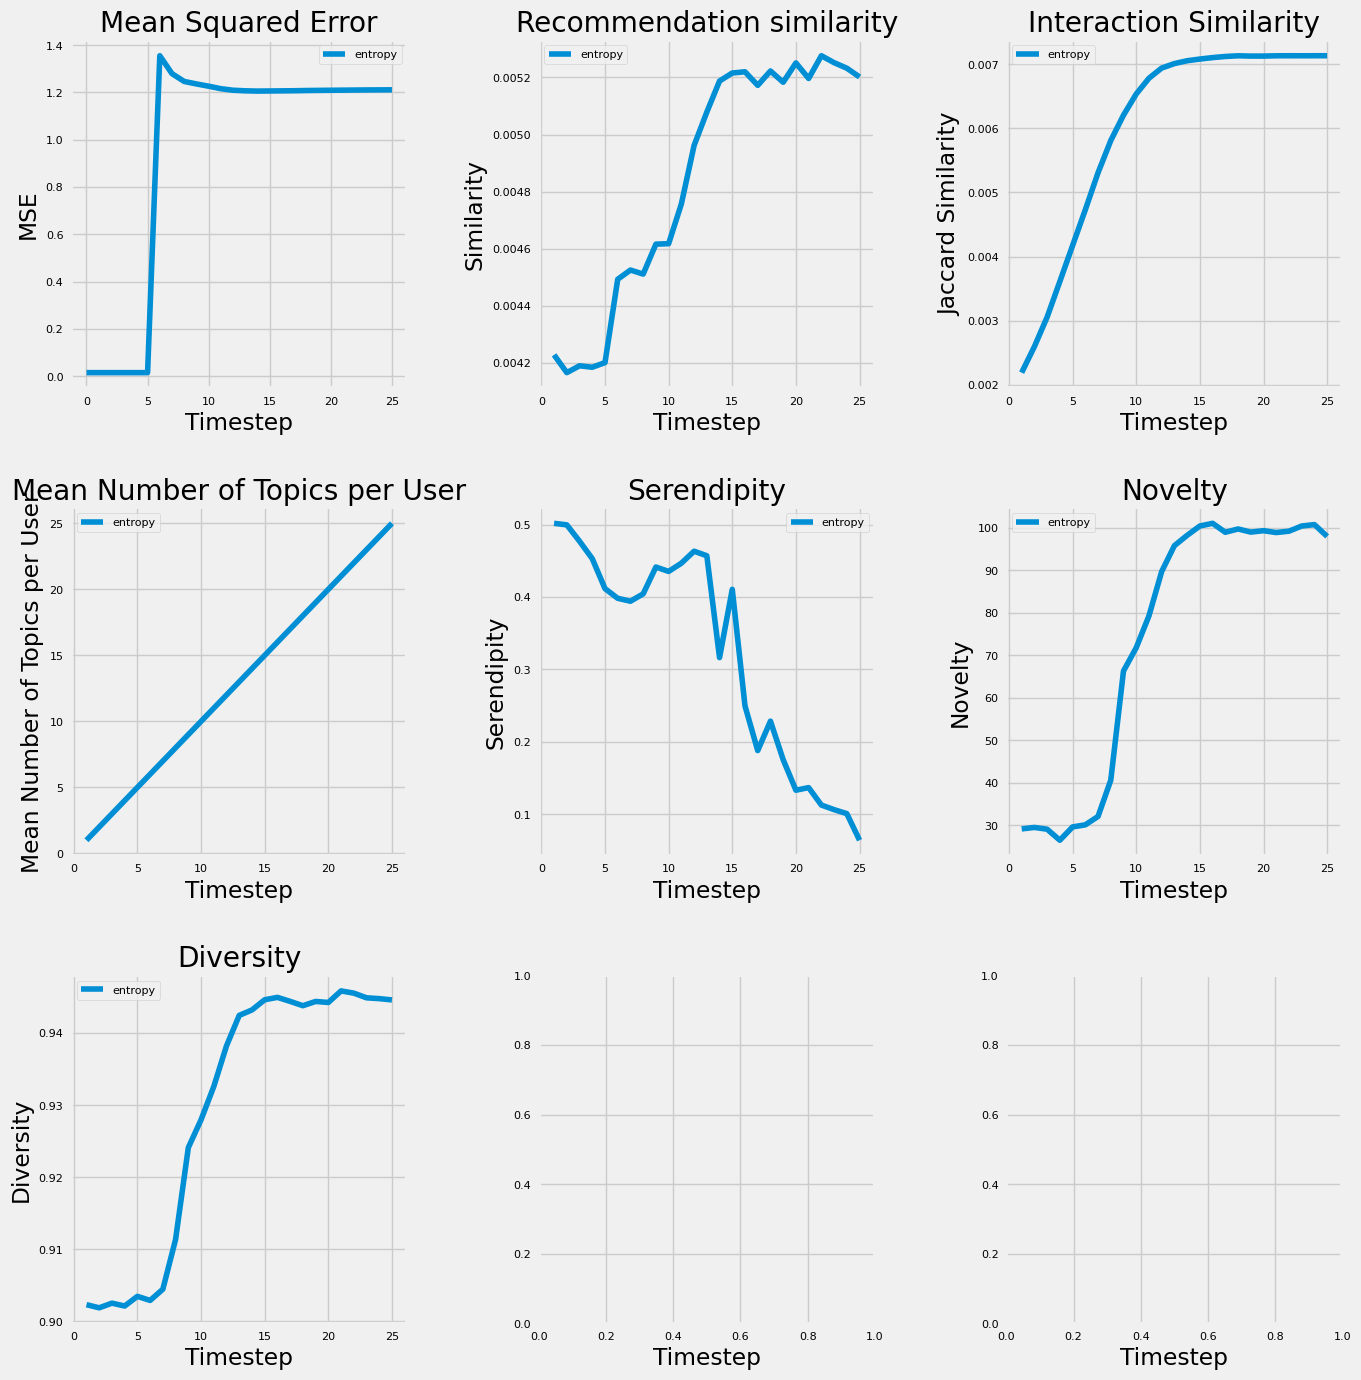

In [114]:
import src
reload(src.utils)
from src.utils import *
    
# Save measurements
measurements_path = f'artefacts/measurements/{model_name}_measurements_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{alpha}Lambda.csv'
measurements_df = load_or_create_measurements_df(model, model_name, train_timesteps, measurements_path)
plot_measurements([measurements_df])

# Analysis

In [25]:
def load_measurements(path):
    dfs = []
    data = []
    numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
    columns = ['model_name'] + numeric_cols
    
    for file in os.listdir(path):
        if file.endswith('.csv'):
            file_name = file[:-4]
            params = file_name.split('_')
            params_start_id = params.index('measurements')
            model_name = '_'.join(params[:params_start_id])
            row = []
            row.append(model_name)
            for col in columns:
                for param in params:
                    if param.endswith(col):
                        value = param[:param.find(col)]
                        row.append(value)
            data.append(row)
            df = pd.read_csv(path + '/' + file)
            dfs.append(df)
    
    parameters_df = pd.DataFrame(data, 
                                 columns=columns)                                
    for param in parameters_df.columns:
        if param in numeric_cols:
            parameters_df[param] = pd.to_numeric(parameters_df[param])
    return dfs, parameters_df

dfs, parameters_df = load_measurements('artefacts/measurements')

In [26]:
# filter plots by parameters
parameters_df_filtered = parameters_df[
    ((parameters_df['model_name'] == 'cosine_sim') | (parameters_df['model_name'] == 'myopic')) & 
    (parameters_df['trainTimesteps'] == 1)
]

indexes = parameters_df_filtered.index.values
parameters_df_filtered = parameters_df_filtered.reset_index().drop(columns=['index'])

dfs_filtered = [dfs[x] for x in indexes]

Number of Iterations for NMF:  1000
Number of Attributes:  [500]
Number of Clusters:  [50]
Training Timesteps:  [1]
Running Timesteps:  [1]
Lambda:  [0.1 nan]


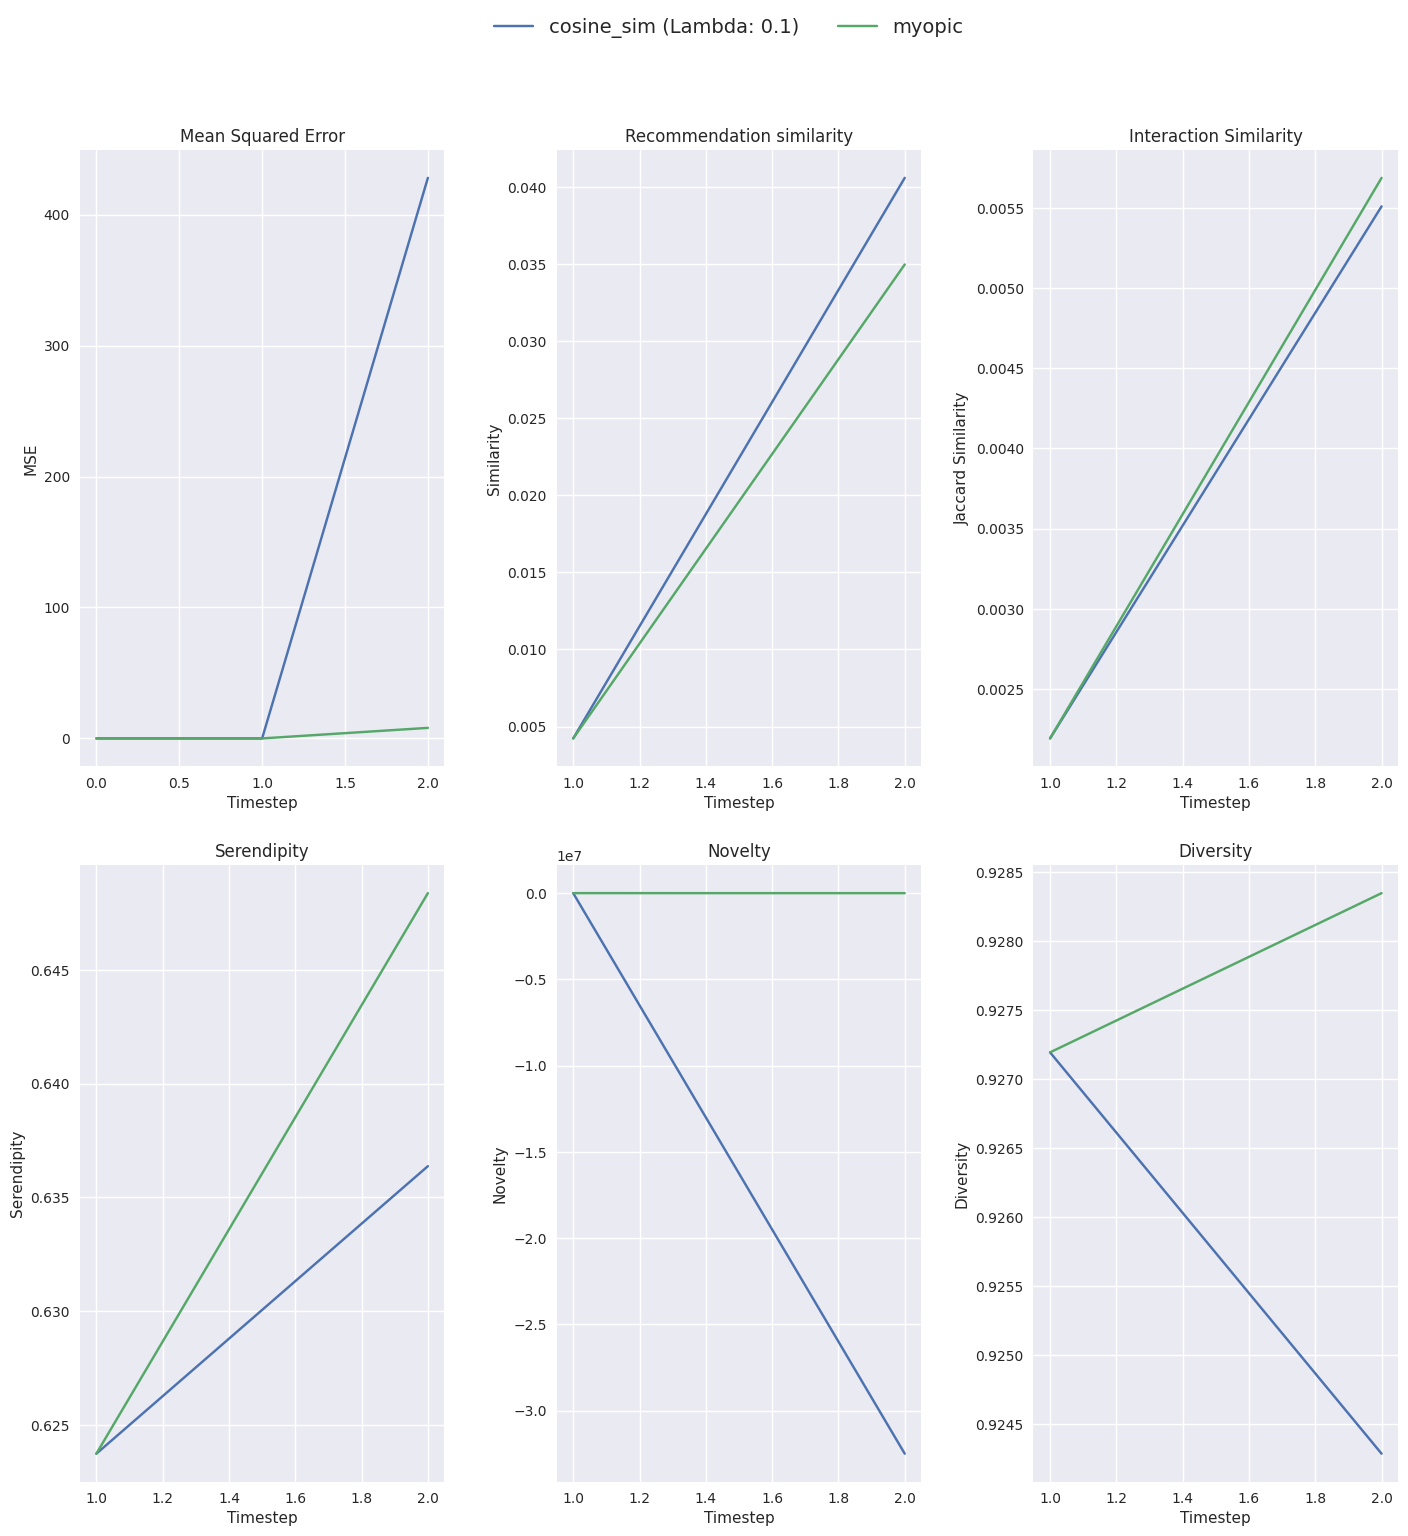

In [27]:
plot_measurements(dfs_filtered, parameters_df_filtered)
print("Number of Iterations for NMF: ", max_iter)
print("Number of Attributes: ", np.unique(parameters_df_filtered['nAttrs']))
print("Number of Clusters: ", np.unique(parameters_df_filtered['nClusters']))
print("Training Timesteps: ", np.unique(parameters_df_filtered['trainTimesteps']))
print("Running Timesteps: ", np.unique(parameters_df_filtered['runTimesteps']))
print("Lambda: ", np.unique(parameters_df_filtered['Lambda']))

In [28]:
serendipities = []
summary_df = pd.DataFrame()
                          
for df in dfs:
    row = df[df['state']=='run'].groupby('model').agg(
        MSE=('mse', 'last'),
        Diversity=('diversity_metric', 'mean'),
        Novelty=('novelty_metric', 'mean'),
        Serendipity=('serendipity_metric', 'mean'),
        Timesteps=('timesteps', 'max'))
    summary_df = summary_df.append(row)

In [127]:
summary_df

,MSE,Diversity,Novelty,Serendipity,Timesteps
model,,,,,
myopic_prob,5.579149,0.911582,383.181227,0.494910,4
myopic,2.993409,0.954995,702.503845,0.111384,210
cosine_sim,4.182879,0.942613,111.821895,0.000000,150
cosine_sim,20.154114,0.928588,279.015566,0.614979,4
cosine_sim,6.014604,0.916687,184.767651,0.280506,110
cosine_sim,4.425485,0.956005,644.185321,0.233893,110
myopic,6.863434,0.942014,113.843558,0.000000,150
entropy,2.697645,0.942496,103.787265,0.434443,10
cosine_sim,23.702580,0.916096,183.281493,0.275429,110
